In [1]:
import os
import numpy as np
import pandas as pd
import cv2

# Load images
Courtesy of GTSRB website

In [2]:
import matplotlib.pyplot as plt
import csv

# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader)  # skip header 
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels


I,L = readTrafficSigns("E:\\Semester2\\Machine Learning\\GTSRB_Data\\Final_Training\\images")

In [3]:
print("Total images:", len(I))
print("Total labels:", len(L))
if(len(I)==len(L)):
    print("No mismatches detected")

Total images: 39209
Total labels: 39209
No mismatches detected


In [4]:
#resize to 32x32
I = [cv2.resize(img, (32, 32)) for img in I]

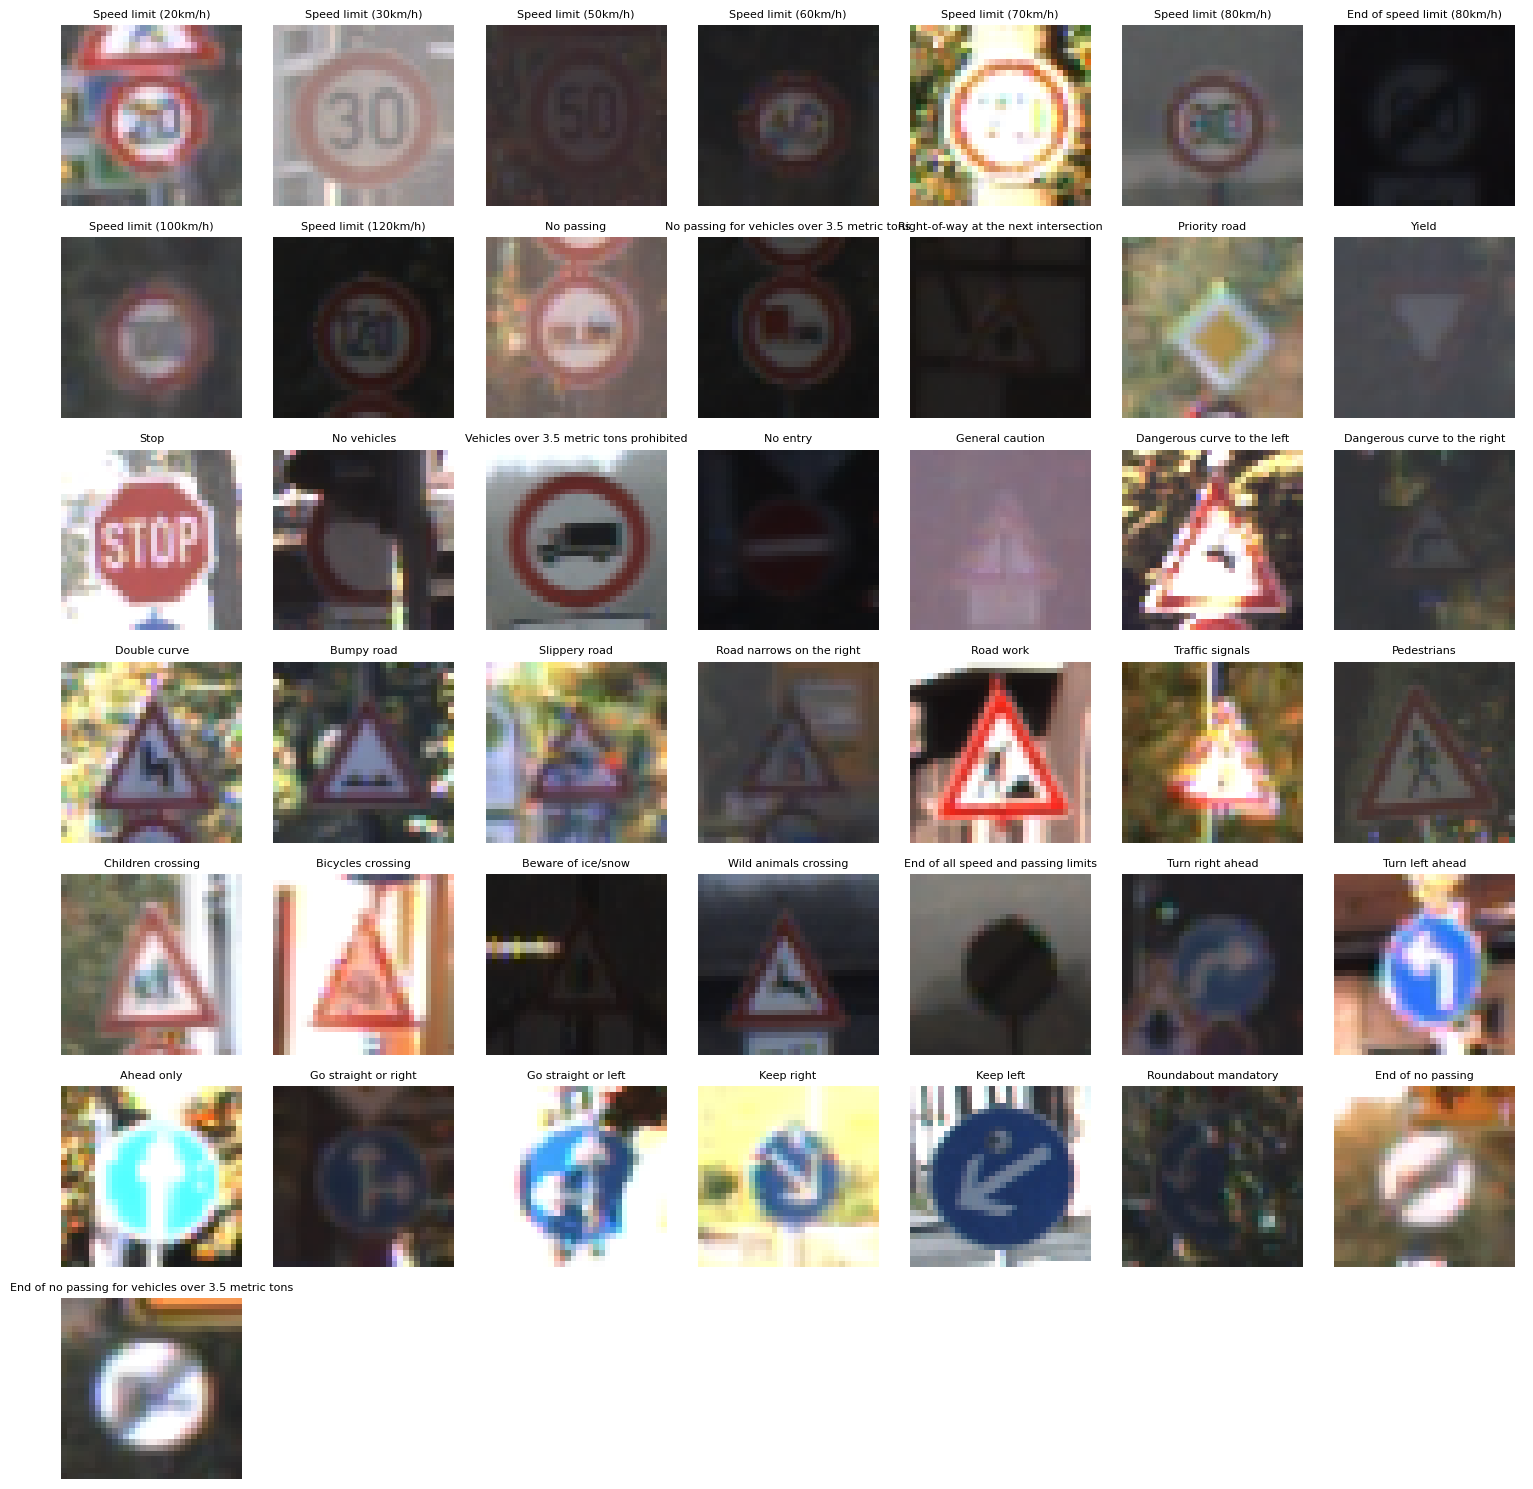

In [5]:
import matplotlib.pyplot as plt

class_names = {
    0: "Speed limit (20km/h)", 1: "Speed limit (30km/h)", 2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)", 4: "Speed limit (70km/h)", 5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)", 7: "Speed limit (100km/h)", 8: "Speed limit (120km/h)",
    9: "No passing", 10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection", 12: "Priority road", 13: "Yield",
    14: "Stop", 15: "No vehicles", 16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry", 18: "General caution", 19: "Dangerous curve to the left",
    20: "Dangerous curve to the right", 21: "Double curve", 22: "Bumpy road",
    23: "Slippery road", 24: "Road narrows on the right", 25: "Road work",
    26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing",
    29: "Bicycles crossing", 30: "Beware of ice/snow", 31: "Wild animals crossing",
    32: "End of all speed and passing limits", 33: "Turn right ahead",
    34: "Turn left ahead", 35: "Ahead only", 36: "Go straight or right",
    37: "Go straight or left", 38: "Keep right", 39: "Keep left",
    40: "Roundabout mandatory", 41: "End of no passing",
    42: "End of no passing for vehicles over 3.5 metric tons"
}



images_per_class = {}

#Loop through the list of labels and images (I, L) 
for image, label in zip(I, L):
                                        #Stores the first image in each class
    if label not in images_per_class:
        images_per_class[label] = image

fig, axes = plt.subplots(7, 7, figsize=(15, 15))  
axes = axes.flatten()  

#Loop through the images_per_class dictionary and plot the images
for idx, (label, image) in enumerate(images_per_class.items()):
    axes[idx].imshow(image) 
    axes[idx].set_title(class_names[int(label)], fontsize=8)  
    axes[idx].axis('off')  

for i in range(len(images_per_class), len(axes)):
    axes[i].axis('off')

plt.tight_layout() 
plt.show()

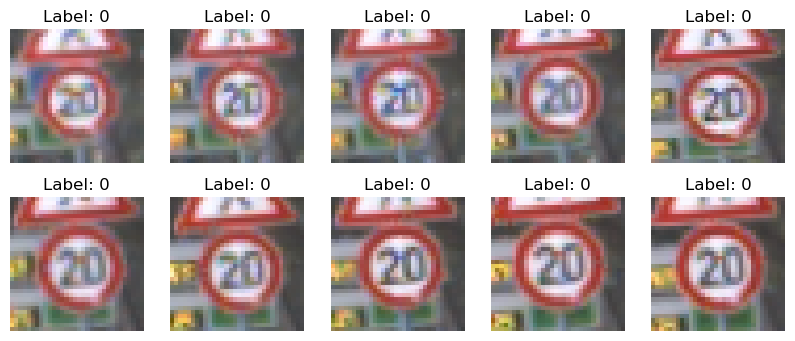

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))  #2 rows and 5columns
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(I[i])  
    axes[i].set_title(f"Label: {L[i]}") 
    axes[i].axis("off") 

plt.show()

# Random forest

In [10]:
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def extract_hog_features(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    image = cv2.resize(image, (32, 32))  # Resize to 32x32
    features, _ = hog(image, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True)
    return features

# Function to read images and extract features
def load_data_with_features(rootpath):
    features = []
    labels = []

    for c in range(43):  # Loop over all 43 classes
        prefix = os.path.join(rootpath, format(c, '05d'))  # Class folder
        csv_file = os.path.join(prefix, 'GT-' + format(c, '05d') + '.csv')

        # Read CSV file
        df = pd.read_csv(csv_file, delimiter=';')

        for index, row in df.iterrows():
            img_path = os.path.join(prefix, row['Filename'])  # Get image path
            img = cv2.imread(img_path)  # Read image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

            # Extract HOG features
            hog_features = extract_hog_features(img)

            features.append(hog_features)
            labels.append(int(row['ClassId']))

    return np.array(features), np.array(labels)

# Load dataset
X, y = load_data_with_features("E:\\Semester2\\Machine Learning\\GTSRB_Data\\Final_Training\\images")

# Print dataset shape
print("Feature shape:", X.shape)
print("Number of images:", len(y))

Feature shape: (39209, 1764)
Number of images: 39209


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42,n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

#Evals
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[class_names[i] for i in sorted(class_names.keys())]))

Random Forest Accuracy: 0.9404488650854373
Classification Report:
                                                      precision    recall  f1-score   support

                               Speed limit (20km/h)       1.00      0.53      0.69        38
                               Speed limit (30km/h)       0.89      0.89      0.89       496
                               Speed limit (50km/h)       0.81      0.89      0.85       450
                               Speed limit (60km/h)       0.95      0.86      0.90       280
                               Speed limit (70km/h)       0.95      0.96      0.95       418
                               Speed limit (80km/h)       0.78      0.76      0.77       364
                        End of speed limit (80km/h)       1.00      0.95      0.97        59
                              Speed limit (100km/h)       0.89      0.94      0.91       278
                              Speed limit (120km/h)       0.88      0.89      0.88       301
  